In [1]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import sys

sys.path.append(r"E:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\libs")

from libs.utils import *

# I. Load và xử lý dữ liệu:

In [2]:
DATASET_PATH = r"E:\Learn Machine Learning\Project\Opinion Classifier\res\dataset\tf-idf-not-remv-stopwords.csv"

data : pd.DataFrame = read_dataset(DATASET_PATH, "csv", header=0)

data.head()

15:05:24 root INFO: Đang đọc dữ liệu từ file E:\Learn Machine Learning\Project\Opinion Classifier\res\dataset\tf-idf-not-remv-stopwords.csv ...
		at Line 274 [read_dataset() in utils.py, utils]
15:05:29 root INFO: Đọc thành công! 
		at Line 282 [read_dataset() in utils.py, utils]


,Unnamed: 0,máu_đơn,trốn,hiến,tham_gia,part,từ_khoá,đky,ạ,cay,...,quạo,công_chính,36,thành_đoàn,hà,ngắn,”,giải_lao,đàn_bà,label
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Neutral
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Negative
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.39841,0.0,0.0,Neutral


Loại bỏ cột đầu tiên do rõ ràng không cần thiết (chỉ chạy một lần):

In [3]:
data = data.drop(columns=data.columns.values[0], axis=1)
data.head()

,máu_đơn,trốn,hiến,tham_gia,part,từ_khoá,đky,ạ,cay,phục_vụ_việc,...,quạo,công_chính,36,thành_đoàn,hà,ngắn,”,giải_lao,đàn_bà,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Neutral
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Negative
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.39841,0.0,0.0,Neutral



Lọc các lớp có trong tập huấn luyện:

In [4]:
labels : list[str] = data["label"].unique().tolist()
labels.sort(reverse=True)
labels

['Positive', 'Neutral', 'Negative']

Thống kê số mẫu:

In [5]:
n_samples_classes = data["label"].value_counts().to_dict()
n_samples_classes

{'Positive': 1032, 'Neutral': 754, 'Negative': 490}

Thực hiện đánh trọng số cho các lớp theo công thức:

        class_weight = n_samples / (n_classes * n_samples_class_k)

, trong đó:
* `n_samples` là tổng số đối tượng tập huấn luyện. 
* `n_classes` là tổng số lớp. 
* `n_sample_class_k` là tổng số đối tượng tập huấn luyện thuộc lớp k.
* `class_weight` là trọng số của lớp k.


In [6]:
n_samples : int = len(data)
class_weight : dict[str, float] = {k : n_samples / (len(labels) * n_samples_classes.get(k)) for k in n_samples_classes}
class_weight

{'Positive': 0.7351421188630491,
 'Neutral': 1.0061892130857648,
 'Negative': 1.5482993197278911}

Phân chia tập dữ liệu thành tập huấn luyện và tập kiểm thử:

In [7]:
training_set, testing_set = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
training_set[:10]

,máu_đơn,trốn,hiến,tham_gia,part,từ_khoá,đky,ạ,cay,phục_vụ_việc,...,quạo,công_chính,36,thành_đoàn,hà,ngắn,”,giải_lao,đàn_bà,label
2084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.233446,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.39841,0.0,0.0,Positive
1963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
1691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Negative
2111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Neutral
450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Negative
1860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.233446,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Neutral
812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Neutral
1910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive


In [8]:
X_train : pd.DataFrame = training_set.drop(columns="label", axis=1)
y_train : pd.Series = training_set["label"].copy()
X_testing : pd.DataFrame = testing_set.drop(columns="label", axis=1)
y_testing : pd.Series = testing_set["label"].copy()


Chuyển nhãn của tập huấn luyện sang dạng số (Thuận tiện cho tính toán)

In [10]:
y_train_encode = y_train.apply(lambda x : {label : i for i, label in enumerate(labels)}.get(x))
y_train_encode.head()

2084    0
1963    0
8       0
1691    2
2111    1
Name: label, dtype: int64

Tính toán trọng số của lớp cho từng lớp

In [12]:
y_encode_label = {label : i for i, label in enumerate(labels)}

class_weight = {y_encode_label.get(k) : class_weight.get(k) for k in class_weight}
class_weight

{0: 0.7351421188630491, 1: 1.0061892130857648, 2: 1.5482993197278911}

# 2. Huấn luyện mô hình:

Huấn luyện thử các mô hình đặc trưng

e:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:

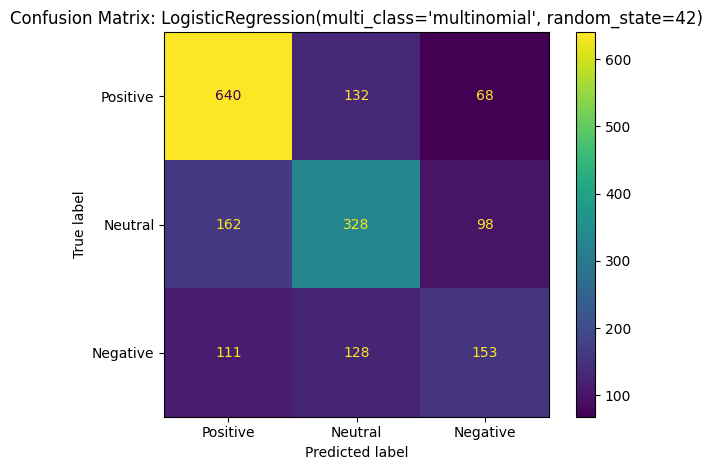

21:34:42 root INFO: 
Average: None
Precision:	[0.70098576 0.55782313 0.47962382]
Recall:		[0.76190476 0.55782313 0.39030612]
--> F1-score:	[0.73017684 0.55782313 0.43037975]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.70098576, 0.55782313, 0.47962382]),
 array([0.76190476, 0.55782313, 0.39030612]),
 array([0.73017684, 0.55782313, 0.43037975]))

In [26]:
lgt_reg = LogisticRegression(random_state=42, multi_class="multinomial", fit_intercept=True)

lgt_reg.fit(X_train, y_train_encode)

measure_score(lgt_reg, X_train, y_train_encode, average=None, labels=labels, cv=10, fig_title="LogisticRegressionTFIDFDefault")


21:19:27 root INFO: Saving figure 'LogisticRegressionTFIDFDefault2' ...
		at Line 62 [save_fig() in utils.py, utils]
21:19:28 root INFO: Saved figure 'LogisticRegressionTFIDFDefault2'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LogisticRegressionTFIDFDefault2.png
		at Line 66 [save_fig() in utils.py, utils]


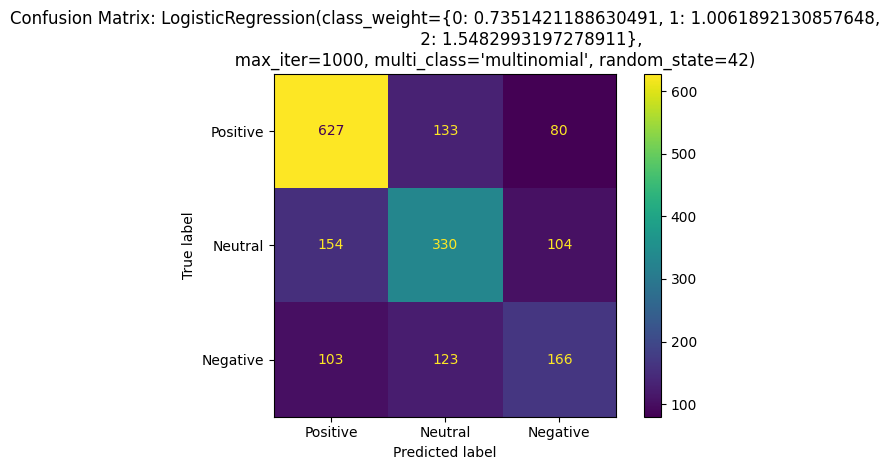

21:19:28 root INFO: 
Average: None
Precision:	[0.70927602 0.56313993 0.47428571]
Recall:		[0.74642857 0.56122449 0.42346939]
--> F1-score:	[0.72737819 0.56218058 0.44743935]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.70927602, 0.56313993, 0.47428571]),
 array([0.74642857, 0.56122449, 0.42346939]),
 array([0.72737819, 0.56218058, 0.44743935]))

In [16]:
lgt_reg = LogisticRegression(
    random_state=42,
    multi_class="multinomial",
    fit_intercept=True,
    class_weight=class_weight,
    max_iter=1000
)

lgt_reg.fit(X_train, y_train_encode)

measure_score(lgt_reg, X_train, y_train_encode, average=None, labels=labels, cv=10, fig_title="LogisticRegressionTFIDFDefault2")

23:44:42 root INFO: Saving figure 'LogisticRegressionTFIDFDefault3' ...
		at Line 62 [save_fig() in utils.py, utils]
23:44:43 root INFO: Saved figure 'LogisticRegressionTFIDFDefault3'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LogisticRegressionTFIDFDefault3.png
		at Line 66 [save_fig() in utils.py, utils]


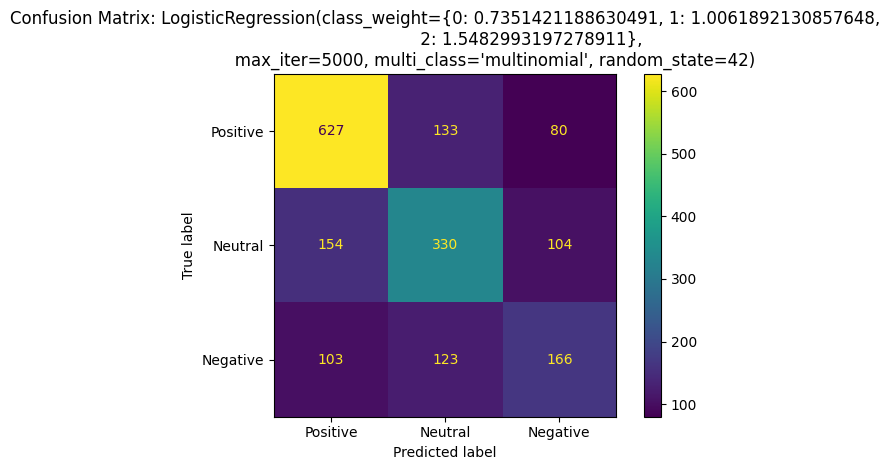

23:44:44 root INFO: 
Average: None
Precision:	[0.70927602 0.56313993 0.47428571]
Recall:		[0.74642857 0.56122449 0.42346939]
--> F1-score:	[0.72737819 0.56218058 0.44743935]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.70927602, 0.56313993, 0.47428571]),
 array([0.74642857, 0.56122449, 0.42346939]),
 array([0.72737819, 0.56218058, 0.44743935]))

In [33]:
lgt_reg = LogisticRegression(
    random_state=42,
    multi_class="multinomial",
    fit_intercept=True,
    class_weight=class_weight,
    max_iter=5000,
)

lgt_reg.fit(X_train, y_train_encode)

measure_score(lgt_reg, X_train, y_train_encode, average=None, labels=labels, cv=10, fig_title="LogisticRegressionTFIDFDefault3")

Tinh chỉnh tham số mô hình khi no-scaler

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s finished
16:16:09 root INFO: Best esitmator params: {'C': 0.004520353656360241, 'penalty': 'l2'}
		at Line 28 [<module>() in 3763615479.py, 3763615479]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[Pa

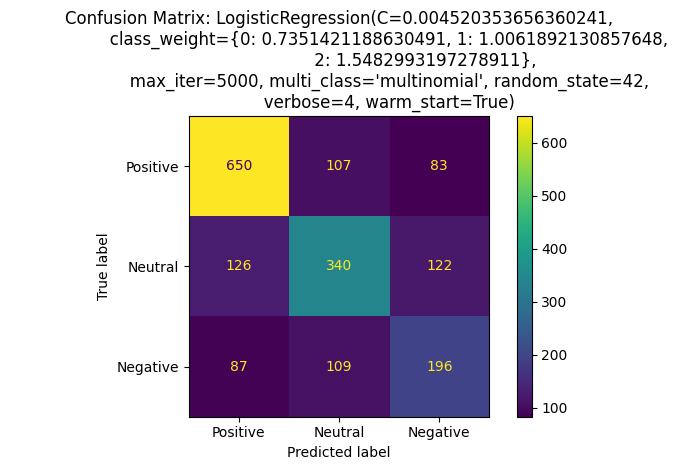

16:17:12 root INFO: 
Average: macro
Precision:	0.617825134915517
Recall:		0.6173469387755102
--> F1-score:	0.6173632399386373
		at Line 241 [get_reported_score() in utils.py, utils]


(0.617825134915517, 0.6173469387755102, 0.6173632399386373)

In [14]:
lgt_reg_params = {
    "C" : np.logspace(-4, 4, 30),
    "penalty" : ['l2', None],
    # "max_iter" : [100, 500, 1000, 2000, 5000],
    # "tol" : [1e-6, 1e-5, 1e-4]
}

lgt_reg_grid = GridSearchCV(
    LogisticRegression(
        random_state=42,
        multi_class="multinomial",
        fit_intercept=True,
        class_weight=class_weight,
        max_iter=5000,
        verbose=4,
        warm_start=True,
    ),
    lgt_reg_params,
    scoring="f1_macro",
    n_jobs=-1,
    cv=5,
    verbose=4,
    return_train_score=True,
)

lgt_reg_grid.fit(X_train, y_train_encode)

logging.info("Best esitmator params: " + str(lgt_reg_grid.best_params_))

measure_score(lgt_reg_grid.best_estimator_, X_train, y_train_encode, average="macro", labels=labels, cv=10, fig_title="LogisticRegressionGridSearch")

In [15]:
save_model("logistic_regression.pkl", lgt_reg_grid.best_estimator_)

16:19:00 root INFO: Đang lưu lại mô hình...
		at Line 88 [save_model() in utils.py, utils]
16:19:00 root INFO: Lưu thành công!
		at Line 92 [save_model() in utils.py, utils]


Huấn luyện một mô hình có scale data trước khi huấn luyện:

00:44:31 root INFO: Saving figure 'LogisticRegressionScaledData' ...
		at Line 62 [save_fig() in utils.py, utils]
00:44:32 root INFO: Saved figure 'LogisticRegressionScaledData'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LogisticRegressionScaledData.png
		at Line 66 [save_fig() in utils.py, utils]


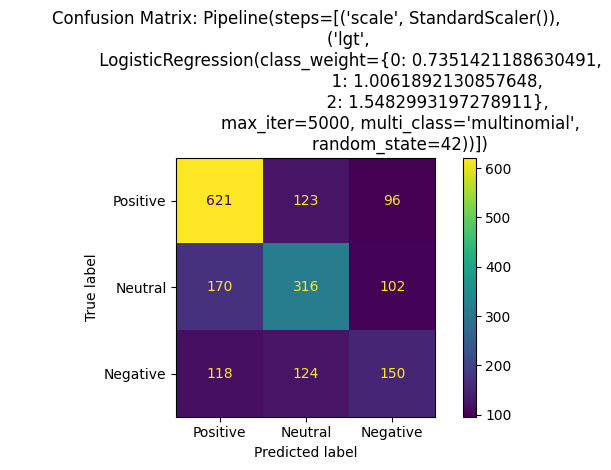

00:44:33 root INFO: 
Average: None
Precision:	[0.68316832 0.56127886 0.43103448]
Recall:		[0.73928571 0.53741497 0.38265306]
--> F1-score:	[0.71012007 0.54908775 0.40540541]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.68316832, 0.56127886, 0.43103448]),
 array([0.73928571, 0.53741497, 0.38265306]),
 array([0.71012007, 0.54908775, 0.40540541]))

In [35]:
lgt_reg_pipeline = Pipeline(
    [
        ("scale", StandardScaler()),
        ("lgt", LogisticRegression(
            random_state=42,
            multi_class="multinomial",
            fit_intercept=True,
            class_weight=class_weight,
            max_iter=5000,
        ))
    ]
)

lgt_reg_pipeline.fit(X_train, y_train_encode)

measure_score(lgt_reg_pipeline, X_train, y_train_encode, average=None, labels=labels, cv=10, fig_title="LogisticRegressionScaledData")

Tinh chỉnh tham số siêu mô hình có scale dữ liệu trước khi huấn luyện:

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
17:01:25 root INFO: Best esitmator params: {'lgt__C': 0.0012689610031679222, 'lgt__penalty': 'l2'}
		at Line 36 [<module>() in 3146705961.py, 3146705961]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining: 

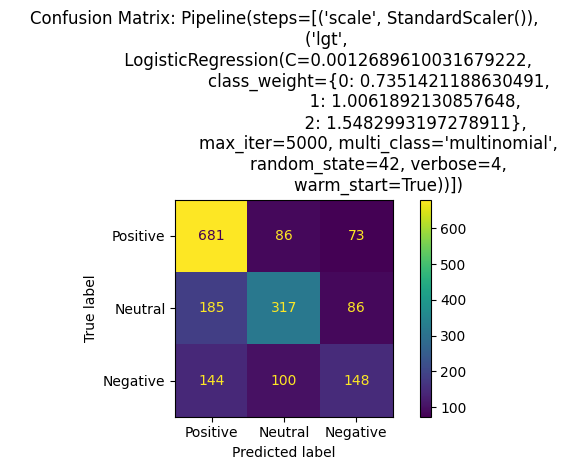

17:02:17 root INFO: 
Average: None
Precision:	[0.67425743 0.63021869 0.48208469]
Recall:		[0.81071429 0.53911565 0.37755102]
--> F1-score:	[0.73621622 0.58111824 0.42346209]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.67425743, 0.63021869, 0.48208469]),
 array([0.81071429, 0.53911565, 0.37755102]),
 array([0.73621622, 0.58111824, 0.42346209]))

In [16]:
lgt_reg_pipeline = Pipeline(
    [
        ("scale", StandardScaler()),
        ("lgt", LogisticRegression(
            random_state=42,
            multi_class="multinomial",
            fit_intercept=True,
            class_weight=class_weight,
            max_iter=5000,
            warm_start=True,
            verbose=4
            
        ))
    ]
)

lgt_reg_params = {
    "lgt__C" : np.logspace(-4, 4, 30),
    "lgt__penalty" : ['l2', None],
    # "max_iter" : [100, 500, 1000, 2000, 5000],
    # "tol" : [1e-6, 1e-5, 1e-4]
}

lgt_reg_grid = GridSearchCV(
    lgt_reg_pipeline,
    lgt_reg_params,
    scoring="f1_macro",
    n_jobs=-1,
    cv=5,
    verbose=4,
    return_train_score=True,
)

lgt_reg_grid.fit(X_train, y_train_encode)

logging.info("Best esitmator params: " + str(lgt_reg_grid.best_params_))

measure_score(lgt_reg_grid.best_estimator_, X_train, y_train_encode, average=None, labels=labels, cv=10, fig_title="LogisticRegressionGridSearchScaled")

In [17]:
save_model("logistic_regression_scaled.pkl", lgt_reg_grid.best_estimator_)

17:10:16 root INFO: Đang lưu lại mô hình...
		at Line 88 [save_model() in utils.py, utils]
17:10:16 root INFO: Lưu thành công!
		at Line 92 [save_model() in utils.py, utils]


Sử dụng over-sample để khắc phục tình trạng imbalance của lớp:

In [95]:
training_set.head(10)

,máu_đơn,trốn,hiến,tham_gia,part,từ_khoá,đky,ạ,cay,phục_vụ_việc,...,quạo,công_chính,36,thành_đoàn,hà,ngắn,”,giải_lao,đàn_bà,label
2084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.233446,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.39841,0.0,0.0,Positive
1963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
1691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Negative
2111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Neutral
450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive
316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Negative
1860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.233446,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Neutral
812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Neutral
1910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,Positive


In [96]:
from sklearn.utils import resample

Tách và tính độ lớn các mẫu của từng lớp riêng biệt:

In [110]:
training_set_positive = training_set[training_set["label"] == "Positive"]
training_set_negative = training_set[training_set["label"] == "Negative"]
training_set_neutral = training_set[training_set["label"] == "Neutral"]

In [111]:
print(len(training_set_positive))
print(len(training_set_negative))
print(len(training_set_neutral))

840
392
588


chọn ra các mẫu ngẫu nhiên trong các tập negative và neutral, sau đó nối thêm vào tập ban đầu để mở rộng thêm tập negative và tập neutral

In [112]:
training_set_negative_resample = resample(training_set_negative, n_samples=len(training_set_positive) - len(training_set_negative), random_state=42, stratify=None)
training_set_neutral_resample = resample(training_set_neutral, n_samples=len(training_set_positive) - len(training_set_neutral), random_state=42, stratify=None)


In [115]:
training_set_negative = pd.concat([training_set_negative, training_set_negative_resample])
training_set_neutral = pd.concat([training_set_neutral, training_set_neutral_resample])


Nối ba tập đã oversample lại và tạo thành tập hoàn chỉnh

In [117]:
training_set_resample = pd.concat([training_set_positive, training_set_negative, training_set_neutral])

In [118]:
for x in [training_set_positive, training_set_negative, training_set_neutral]:
    print(len(x))

840
840
840


In [128]:
len(training_set_resample)

2520

In [129]:
X_train_resample : pd.DataFrame = training_set_resample.drop(columns="label", axis=1)
y_train_resample : pd.Series = training_set_resample["label"].copy()

In [130]:
y_train_resample.value_counts()

Positive    840
Negative    840
Neutral     840
Name: label, dtype: int64

In [131]:
y_train_encode_resample = y_train_resample.apply(lambda x : {label : i for i, label in enumerate(labels)}.get(x))

y_train_encode_resample.value_counts()

0    840
2    840
1    840
Name: label, dtype: int64

01:38:53 root INFO: Saving figure 'LogisticRegressionOversample' ...
		at Line 62 [save_fig() in utils.py, utils]
01:38:54 root INFO: Saved figure 'LogisticRegressionOversample'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LogisticRegressionOversample.png
		at Line 66 [save_fig() in utils.py, utils]


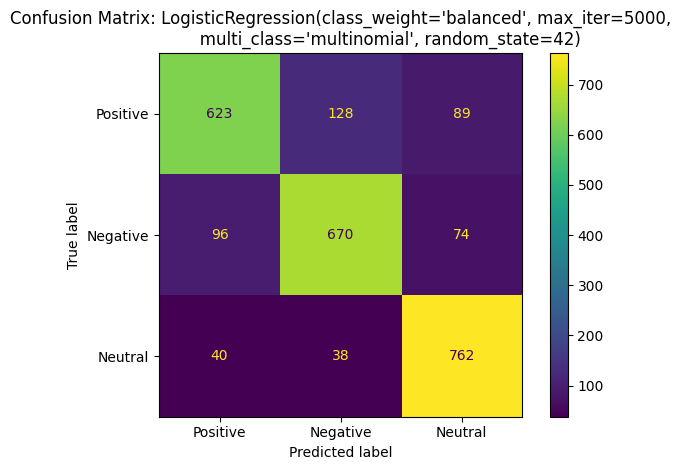

01:38:54 root INFO: 
Average: None
Precision:	[0.82081686 0.80143541 0.82378378]
Recall:		[0.74166667 0.79761905 0.90714286]
--> F1-score:	[0.77923702 0.79952267 0.86345609]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.82081686, 0.80143541, 0.82378378]),
 array([0.74166667, 0.79761905, 0.90714286]),
 array([0.77923702, 0.79952267, 0.86345609]))

In [141]:
lgt_reg = LogisticRegression(
    random_state=42,
    multi_class="multinomial",
    fit_intercept=True,
    class_weight="balanced",
    max_iter=5000,
)

lgt_reg.fit(X_train_resample, y_train_encode_resample)

measure_score(lgt_reg, X_train_resample, y_train_encode_resample, average=None, labels=["Positive", "Negative", "Neutral"], cv=10, fig_title="LogisticRegressionOversample")

Wao! Mô hình sau khi sử dụng oversampling cho ra một kết quả chính xác cao hơn hẳn! Tuy nhiên, có thể mô hình đang bị overfitting dữ liệu nên nó sẽ thể hiện kém khi gặp tập dữ liệu test.

Thử nghiệm với StandardScaler trước khi huấn luyện:

01:47:40 root INFO: Saving figure 'LogisticRegressionScaledData' ...
		at Line 62 [save_fig() in utils.py, utils]
01:47:40 root INFO: Saved figure 'LogisticRegressionScaledData'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LogisticRegressionScaledData.png
		at Line 66 [save_fig() in utils.py, utils]


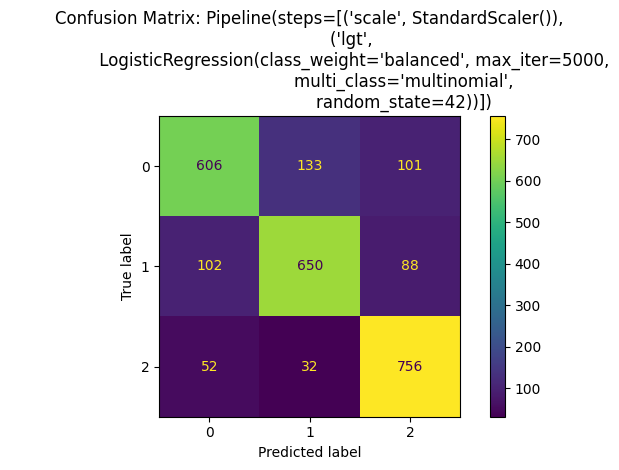

01:47:41 root INFO: 
Average: None
Precision:	[0.79736842 0.79754601 0.8       ]
Recall:		[0.72142857 0.77380952 0.9       ]
--> F1-score:	[0.7575     0.78549849 0.84705882]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.79736842, 0.79754601, 0.8       ]),
 array([0.72142857, 0.77380952, 0.9       ]),
 array([0.7575    , 0.78549849, 0.84705882]))

In [143]:
lgt_reg_pipeline = Pipeline(
    [
        ("scale", StandardScaler()),
        ("lgt", LogisticRegression(
            random_state=42,
            multi_class="multinomial",
            fit_intercept=True,
            class_weight="balanced",
            max_iter=5000,
        )),
    ]
)

lgt_reg_pipeline.fit(X_train_resample, y_train_encode_resample)

measure_score(lgt_reg_pipeline, X_train_resample, y_train_encode_resample, average=None, labels=None, cv=10, fig_title="LogisticRegressionScaledData")

In [138]:
lgt_reg.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 5000,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [144]:
C = np.logspace(-4, 4, 20)
C.shape

(20,)

Tinh chỉnh mô hình trên

In [145]:
lgt_reg_resample_params = {
    "C" : C
}

lgt_reg_resample_grid = GridSearchCV(
    LogisticRegression(
        random_state=42,
        multi_class="multinomial",
        fit_intercept=True,
        class_weight="balanced",
        max_iter=5000,
    ),
    lgt_reg_resample_params,
    scoring="f1_macro",
    n_jobs=-1,
    cv=5,
    verbose=3,
    return_train_score=True
)

lgt_reg_resample_grid.fit(X_train_resample, y_train_encode_resample)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=5000,
                                          multi_class='multinomial',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])},
             return_train_score=True, scoring='f1_macro', verbose=3)

In [146]:
lgt_reg_resample_grid.best_params_

{'C': 0.08858667904100823}

02:26:34 root INFO: Saving figure 'LogisticRegressionGridSearchResample' ...
		at Line 62 [save_fig() in utils.py, utils]
02:26:34 root INFO: Saved figure 'LogisticRegressionGridSearchResample'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LogisticRegressionGridSearchResample.png
		at Line 66 [save_fig() in utils.py, utils]


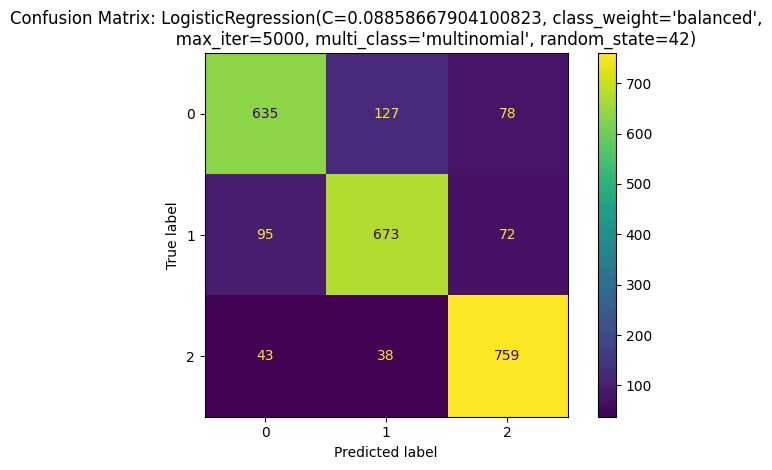

02:26:35 root INFO: 
Average: None
Precision:	[0.82147477 0.80310263 0.8349835 ]
Recall:		[0.75595238 0.80119048 0.90357143]
--> F1-score:	[0.78735276 0.80214541 0.86792453]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.82147477, 0.80310263, 0.8349835 ]),
 array([0.75595238, 0.80119048, 0.90357143]),
 array([0.78735276, 0.80214541, 0.86792453]))

In [147]:
measure_score(lgt_reg_resample_grid.best_estimator_, X_train_resample, y_train_encode_resample, cv=10, labels=None, fig_title="LogisticRegressionGridSearchResample")

In [148]:
save_model("logistic_regression_resample.pkl", lgt_reg_resample_grid.best_estimator_)

02:29:13 root INFO: Đang lưu lại mô hình...
		at Line 88 [save_model() in utils.py, utils]
02:29:13 root INFO: Lưu thành công!
		at Line 92 [save_model() in utils.py, utils]


In [18]:
lgt_reg = load_model(r"E:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\logistic_regression.pkl")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

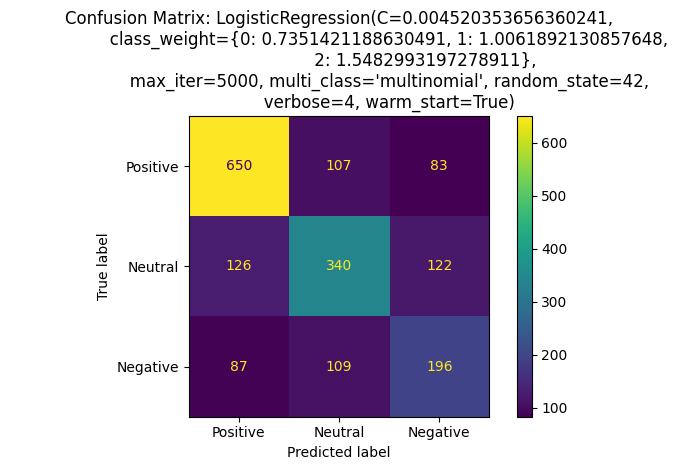

17:46:06 root INFO: 
Average: None
Precision:	[0.75318656 0.61151079 0.48877805]
Recall:		[0.77380952 0.57823129 0.5       ]
--> F1-score:	[0.76335878 0.59440559 0.49432535]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.75318656, 0.61151079, 0.48877805]),
 array([0.77380952, 0.57823129, 0.5       ]),
 array([0.76335878, 0.59440559, 0.49432535]))

In [21]:
measure_score(lgt_reg, X_train, y_train_encode, None, labels=labels, cv=10, fig_title="LogisticRegressionGridSearch")

# 3. Lựa chọn mô hình

In [23]:
y_test_encode = y_testing.apply(lambda x : {label : i for i, label in enumerate(labels)}.get(x))
len(y_test_encode)

456

Kiểm nghiệm mô hình không resample trên tập kiểm thử:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

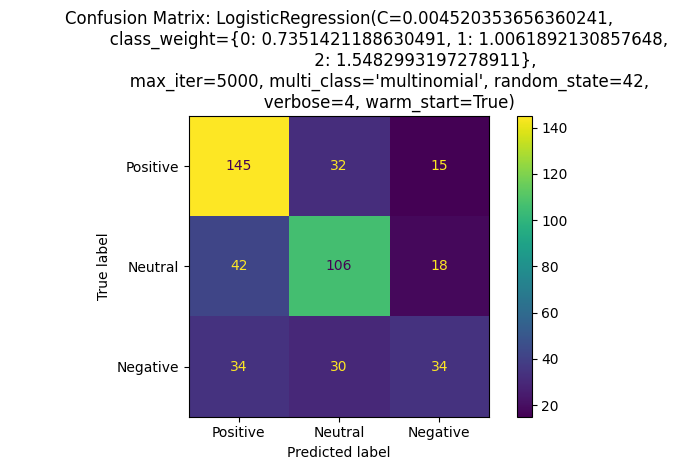

17:53:06 root INFO: 
Average: None
Precision:	[0.6561086  0.63095238 0.50746269]
Recall:		[0.75520833 0.63855422 0.34693878]
--> F1-score:	[0.70217918 0.63473054 0.41212121]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.6561086 , 0.63095238, 0.50746269]),
 array([0.75520833, 0.63855422, 0.34693878]),
 array([0.70217918, 0.63473054, 0.41212121]))

In [24]:
measure_score(load_model("logistic_regression.pkl"), X_testing, y_test_encode, None, labels=labels, cv=10, fig_title="LogisticRegressionTesting")

17:54:21 root INFO: Saving figure 'LogisticRegressionResampleTesting' ...
		at Line 62 [save_fig() in utils.py, utils]
17:54:21 root INFO: Saved figure 'LogisticRegressionResampleTesting'! File location: e:\Learn Machine Learning\Project\Opinion Classifier\res\tf-idf\image\LogisticRegressionResampleTesting.png
		at Line 66 [save_fig() in utils.py, utils]


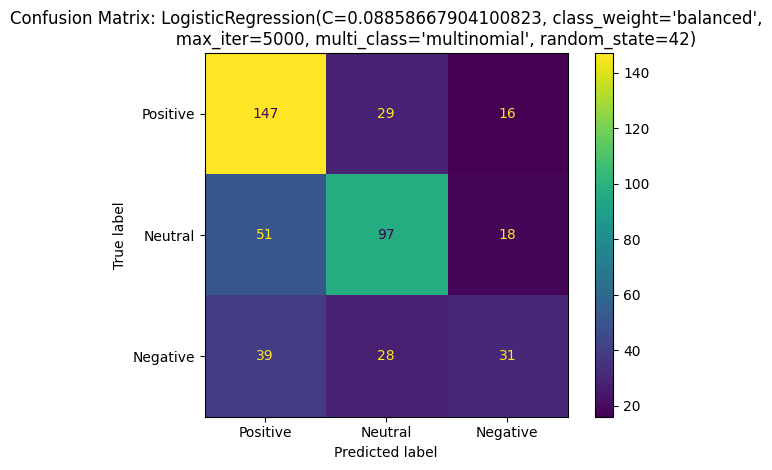

17:54:21 root INFO: 
Average: None
Precision:	[0.62025316 0.62987013 0.47692308]
Recall:		[0.765625   0.58433735 0.31632653]
--> F1-score:	[0.68531469 0.60625    0.3803681 ]
		at Line 241 [get_reported_score() in utils.py, utils]


(array([0.62025316, 0.62987013, 0.47692308]),
 array([0.765625  , 0.58433735, 0.31632653]),
 array([0.68531469, 0.60625   , 0.3803681 ]))

In [25]:
measure_score(load_model("logistic_regression_resample.pkl"), X_testing, y_test_encode, None, labels=labels, cv=10, fig_title="LogisticRegressionResampleTesting")

Như vậy ta sẽ lựa chọn mô hình truyền thống